In [1]:
using CSV, DataFrames, PyPlot, PyCall, StatsBase, ScikitLearn, Statistics

sns = pyimport("seaborn")
sns.set_context("notebook")
sns.set_palette("muted")

# @sk_import svm : LinearSVR
@sk_import feature_selection : RFE
@sk_import model_selection : train_test_split

ENV["COLUMNS"] = 300;

┌ Warning: Module model_selection has been ported to Julia - try `import ScikitLearn: CrossValidation` instead
└ @ ScikitLearn.Skcore C:\Users\cartemic\.julia\packages\ScikitLearn\bo2Pt\src\Skcore.jl:140


Method (Using https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)
* Regression
* Total samples 6497 < 100k
* 12 features... doesn't feel like "few"
* Linear SVR, and SVR with "rbf" kernel if LSVR "doesn't work"

Steps:
* Read in data
* Visualize data
* Shape data for sklearn
* Figure out which input variables are least important
  * Regression with all data
  * https://blog.minitab.com/blog/adventures-in-statistics-2/how-to-identify-the-most-important-predictor-variables-in-regression-models
  * Repeat regression with all but the ith input variable
      * track $\Delta R^{2}$
* Reduce data
* Investigate best train/test split
* 

**try LinearSVR and Linear regression**

## Load Data
Load in red and white wine dataframes, check for the correct number of entries, and combine into a single dataframe

In [2]:
df_red = CSV.read("winequality-red.csv")
n_red = nrow(df_red)
@assert n_red == 1599

df_white = CSV.read("winequality-white.csv")
n_white = nrow(df_white)
@assert n_white == 4898
@assert names(df_red) == names(df_white)

# code red as 1 and white as -1, since 0 would make any beta useless
df_red.color = ones(Int, n_red)
df_white.color = -1 * ones(Int, n_white)

df = [df_red; df_white]
n_wines = n_red + n_white
(df_red, df_white) = (nothing, nothing)
first(df, 5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64
1,7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
2,7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.2,0.68,9.8,5,1
3,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.997,3.26,0.65,9.8,5,1
4,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.998,3.16,0.58,9.8,6,1
5,7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


### Reshape data for sklearn

In [3]:
features = [n for n in names(df) if n != :quality]
n_features = length(features)
X = ones(n_wines, n_features) * NaN
y = df[!, :quality]
for (i, f) in enumerate(features)
    X[:, i] = df[!, f] # ./ maximum(df[!, f])  # scale to eliminate convergence problems due to bad conditioning
    # see https://stackoverflow.com/questions/52670012/convergencewarning-liblinear-failed-to-converge-increase-the-number-of-iterati
end

In [4]:
@sk_import preprocessing : StandardScaler
@sk_import preprocessing : MinMaxScaler
@sk_import preprocessing : RobustScaler
scaler = MinMaxScaler()
scaler.fit(X)
# X = scaler.transform(X)

PyObject MinMaxScaler(copy=True, feature_range=(0, 1))

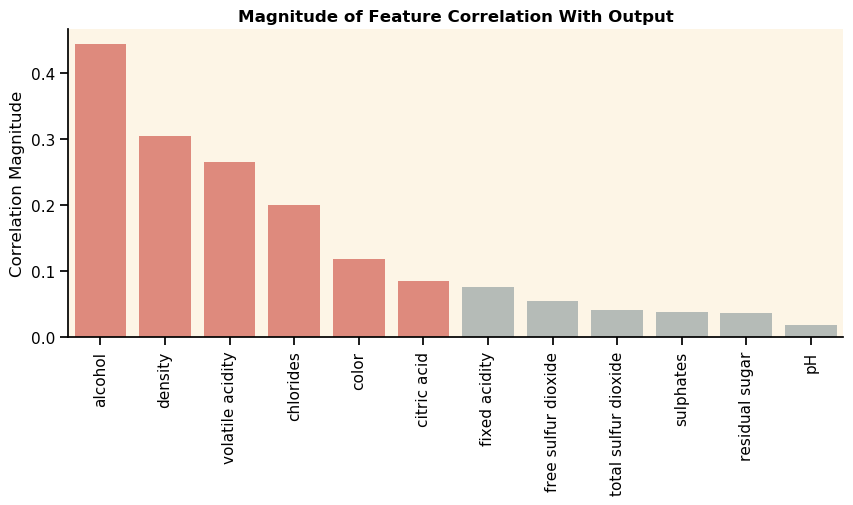

In [336]:
# n_target_features = 6
# fig, ax = subplots(figsize=(10, 4))
# df_features = DataFrame(
#     :features => features,
#     :targets => abs.(pearson_correlation[n_features+1, 1:n_features])
# )
# sort!(df_features, cols=:targets, rev=true)
# facecolor="oldlace"
# palette = [i > n_target_features ? "#95a5a6" : "#e74c3c" for i in 1:n_features]
# sns.barplot(df_features.features, df_features.targets, ax=ax, palette=palette, alpha=0.7)
# ax.set_xticklabels(df_features.features, rotation=90)
# ax.set_ylabel("Correlation Magnitude")
# ax.set_title("Magnitude of Feature Correlation With Output", weight="bold")
# ax.set_facecolor(facecolor)
# sns.despine()

## Define Colors
You can't have good data viz without a decent palette

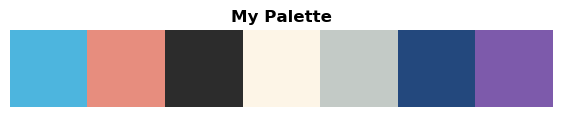

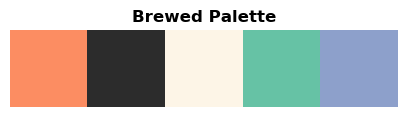

In [148]:
# from colorbrewer, with face and dark colors added by me. They don't appear
# to be black-and-white safe
brewed_colors = Dict(
    :green => "#66c2a5",
    :red =>"#fc8d62",
    :blue => "#8da0cb",
    :face => "#fdf5e7",
    :dark => "#2c2c2c"
)

# colors that I think look nice together, which are black-and-white safe
# (different gray levels when desaturated) as well as colorblind safe per
# investigation via gimp's colorblind simulation filters
my_colors = Dict(
    :face => "#fdf5e7",
    :dark => "#2c2c2c",
    :red => "#e78d7e",
    :lt_blue => "#4db5de",
    :dk_blue => "#23487d",
    :purple => "#7d5aab",
    :gray => "#c3cac6"
)
figure()
sns.palplot([my_colors[c] for c in keys(my_colors)])
title("My Palette", weight="bold")
axis("off")
figure()
sns.palplot([brewed_colors[c] for c in keys(brewed_colors)])
title("Brewed Palette", weight="bold")
axis("off");

In [36]:
# trim down the feature matrix
# features = features[selector.ranking_ .== 1]
# X = X[:, selector.ranking_ .== 1]
y


6497-element Array{Int64,1}:
 5
 5
 5
 6
 5
 5
 5
 7
 7
 5
 5
 5
 5
 ⋮
 7
 7
 5
 6
 6
 6
 5
 6
 5
 6
 7
 6

In [35]:
[X[:, selector.ranking_ .== 1], features[selector.ranking_ .== 1]]

2-element Array{Array,1}:
 [0.14247326517042827 2.188832919994 … 0.1930967712748237 -0.9154641642010458; 0.4510357232102707 3.2822349449551016 … 0.9995786202955752 -0.5800681329544298; … ; -1.3231984105188255 -0.30169391463961837 … -1.0166260022563038 1.9354021013951879; -0.937495337969022 -0.7876503701778853 … -1.4198669267666797 1.0969120232786487]
 Symbol[Symbol("fixed acidity"), Symbol("volatile acidity"), Symbol("residual sugar"), :density, :sulphates, :alcohol]                                                                                                                                                                                                                

In [6]:
features[selector.ranking_ .== 1]

6-element Array{Symbol,1}:
 Symbol("volatile acidity")    
 Symbol("residual sugar")      
 Symbol("free sulfur dioxide") 
 Symbol("total sulfur dioxide")
 :sulphates                    
 :alcohol                      

In [22]:
X[1:5, selector.ranking_ .== 1]

5×6 Array{Float64,2}:
 0.443038  0.0288754  0.0380623  0.875312  0.28   0.630872
 0.556962  0.0395137  0.0865052  0.798005  0.34   0.657718
 0.481013  0.0349544  0.0519031  0.812968  0.325  0.657718
 0.177215  0.0288754  0.0588235  0.78803   0.29   0.657718
 0.443038  0.0288754  0.0380623  0.875312  0.28   0.630872

## Split Data

In [7]:
X_tv, X_test, y_tv, y_test = train_test_split(
    X,
    y,
    train_size=0.8,
    shuffle=true
)
X_train, X_validate, y_train, y_validate = train_test_split(
    X_tv,
    y_tv,
    train_size=0.8,
    shuffle=true
)
println("Data Separated")
println()
println("test points\t\t", length(X_test))
println("train points\t\t", length(X_train))
println("validation points\t", length(X_validate))

Data Separated

test points		15600
train points		49884
validation points	12480


## Feature Selection
feature selection using recursive feature elimination to find out which are the most important features

In [159]:
"""
Trims features using recursive feature elimination
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

# Parameters
X : Feature vector array
y : Target vector
feature_names : Array of feature names corresponding to columns of X
reg : instance of a sklearn estimator, which must output either `coef_` or `feature_importances_`

# Returns
Array of indices of important features (those with a ranking of 1)
"""
function find_important_features(
        X::Array{Float64},
        y::Array{Int64},
        feature_names::Array{Symbol},
        reg::PyObject
    )
    selector = RFE(reg)
    selector.fit(X, y)
    ranking = selector.ranking_
    return [i for i in 1:length(ranking) if ranking[i]==1]
#     return [
#         X[:, selector.ranking_ .== 1],
#         features[selector.ranking_ .== 1]
#     ]
end

find_important_features

In [110]:
reg = LinearSVR()
find_important_features(
    X_train,
    y_train,
    features,
    reg
)

6-element Array{Int64,1}:
  2
  4
  6
  7
  9
 11

## Tune Parameters

In [129]:
@sk_import linear_model : LinearRegression

PyObject <class 'sklearn.linear_model._base.LinearRegression'>

In [167]:
function tune_c_parameter(
        estimator,
        X_train,
        y_train,
        X_validate,
        y_validate;
        c_params=10.0 .^ range(-3, stop=0, length=50)
    )
    scores = [NaN for _ in c_params]
    for (i, C) in enumerate(c_params)
        reg = estimator(C=C)
        reg.fit(X_train, y_train)
        scores[i] = reg.score(X_validate, y_validate)
    end
    return [maximum(scores), c_params[argmax(scores)], scores]
end
tune_c_parameter(
    LinearSVR,
    X_train,
    y_train,
    X_validate,
    y_validate
)

C:\Users\cartemic\AppData\Local\Continuum\anaconda3\envs\DataScience\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\cartemic\AppData\Local\Continuum\anaconda3\envs\DataScience\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\cartemic\AppData\Local\Continuum\anaconda3\envs\DataScience\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\cartemic\AppData\Local\Continuum\anaconda3\envs\DataScience\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\U

3-element Array{Any,1}:
 0.28657800898617203                                                                                                                                                                                                                                                                                                                                                                                                                 
 0.1842069969326716                                                                                                                                                                                                                                                                                                                                                                                                                  
  [0.21860504409127668, 0.22455161841172366, 0.22836518565340905, 0.21883531098282427, 0.23291437044532148, 0.22631477789516896, 0.2

In [161]:
reg = LinearSVR()
important_indices = find_important_features(
    X_train,
    y_train,
    features,
    reg
)
tune_c_parameter(
    LinearSVR,
    X_train[:, important_indices],
    y_train,
    X_validate[:, important_indices],
    y_validate
)

3-element Array{Any,1}:
 0.23486164773800347                                                                                                                                                                                                                                                                                                                                                                                                                     
 0.372759372031494                                                                                                                                                                                                                                                                                                                                                                                                                       
  [-1.2256156217044514, -0.8285171402772984, -0.6355480839163477, -0.486674657422425, -0.3669856977987298, -0.27089727804865

In [169]:
reg = LinearRegression()
reg.fit(X_train, y_train)
reg.score(X_validate, y_validate)

0.305219490055992

In [143]:
@sk_import svm : SVR

PyObject <class 'sklearn.svm._classes.SVR'>

In [170]:
tune_c_parameter(
    SVR,
    X_train,
    y_train,
    X_validate,
    y_validate
)

3-element Array{Any,1}:
 0.15842956609849757                                                                                                                                                                                                                                                                                                                                                                                                                                            
 1.0                                                                                                                                                                                                                                                                                                                                                                                                                                                            
  [-0.00017600703130127293, -1.954932973280421e-7, 0.00022749090611318135, 0.0

In [154]:
tune_c_parameter(
    SVR,
    X_train[:, important_indices],
    y_train,
    X_validate[:, important_indices],
    y_validate
)

3-element Array{Any,1}:
 0.35304752102097764                                                                                                                                                                                                                                                                                                                                                                                                            
 1.0                                                                                                                                                                                                                                                                                                                                                                                                                            
  [0.10978298867554004, 0.11865569773292717, 0.12859802389577857, 0.13957277519798572, 0.1515203585462236, 0.16353185629151656, 0.177000551192

In [171]:
@sk_import tree : DecisionTreeRegressor
reg = DecisionTreeRegressor()
reg.fit(X_train, y_train)
reg.score(X_validate, y_validate)

0.04240067471445663

In [172]:
@sk_import tree : ExtraTreeRegressor
reg = ExtraTreeRegressor()
reg.fit(X_train, y_train)
reg.score(X_validate, y_validate)

0.13206783842666836

In [173]:
@sk_import neighbors : KNeighborsRegressor
reg = KNeighborsRegressor()
reg.fit(X_train, y_train)
reg.score(X_validate, y_validate)

0.1330794679659857

In [174]:
@sk_import neural_network : MLPRegressor
reg = MLPRegressor()
reg.fit(X_train, y_train)
reg.score(X_validate, y_validate)

0.3288940397643757

In [107]:
# @sk_import linear_model : LinearRegression
# @sk_import linear_model : Ridge
# @sk_import linear_model : ElasticNet
# @sk_import linear_model : Lars
# @sk_import linear_model : Lasso
# @sk_import linear_model : LassoLars
# @sk_import linear_model : OrthogonalMatchingPursuit
# @sk_import linear_model : ARDRegression
# @sk_import linear_model : BayesianRidge
# @sk_import linear_model : HuberRegressor
# @sk_import linear_model : RANSACRegressor
# @sk_import linear_model : TheilSenRegressor
# @sk_import linear_model : PassiveAggressiveRegressor
# @sk_import kernel_ridge : KernelRidge
# @sk_import svm : SVR
# @sk_import svm : LinearSVR
# @sk_import svm : NuSVR
# @sk_import ensemble : AdaBoostRegressor
# @sk_import ensemble : BaggingRegressor
# @sk_import ensemble : ExtraTreesRegressor
# @sk_import ensemble : GradientBoostingRegressor
# @sk_import ensemble : RandomForestRegressor
# # @sk_import ensemble : StackingRegressor need input
# # @sk_import ensemble : VotingRegressor need input
# @sk_import gaussian_process : GaussianProcessRegressor
# @sk_import neighbors : KNeighborsRegressor
# @sk_import neighbors : RadiusNeighborsRegressor
# @sk_import neural_network : MLPRegressor
# @sk_import tree : DecisionTreeRegressor
# @sk_import tree : ExtraTreeRegressor

regressors = DataFrame(
    name=["LinearRegression","Ridge","ElasticNet","Lars","Lasso","LassoLars",
            "OrthogonalMatchingPursuit",
            "ARDRegression",
            "BayesianRidge",
            "HuberRegressor",
            "RANSACRegressor",
            "TheilSenRegressor",
            "PassiveAggressiveRegressor",
            "KernelRidge",
            "SVR",
            "LinearSVR",
            "NuSVR",
            "DecisionTreeRegressor",
            "ExtraTreeRegressor",
            "AdaBoostRegressor",
            "BaggingRegressor",
            "ExtraTreesRegressor",
            "GradientBoostingRegressor",
            "RandomForestRegressor",
            "GaussianProcessRegressor",
            "KNeighborsRegressor",
            "RadiusNeighborsRegressor",
            "MLPRegressor",
            "DecisionTreeRegressor",
            "ExtraTreeRegressor"],
        regressor=[LinearRegression,
        Ridge,
        ElasticNet,
        Lars,
        Lasso,
        LassoLars,
        OrthogonalMatchingPursuit,
        ARDRegression,
        BayesianRidge,
        HuberRegressor,
        RANSACRegressor,
        TheilSenRegressor,
        PassiveAggressiveRegressor,
        KernelRidge,
        SVR,
        LinearSVR,
        NuSVR,
        DecisionTreeRegressor,
        ExtraTreeRegressor,
        AdaBoostRegressor,
        BaggingRegressor,
        ExtraTreesRegressor,
        GradientBoostingRegressor,
        RandomForestRegressor,
        GaussianProcessRegressor,
        KNeighborsRegressor,
        RadiusNeighborsRegressor,
        MLPRegressor,
        DecisionTreeRegressor,
        ExtraTreeRegressor]
)
regressors[!, :score] = [NaN for _ in 1:nrow(regressors)]
for i in 1:nrow(regressors)
    reg = regressors[i, :regressor]()
    reg.fit(X_train, y_train)
    score = reg.score(X_validate, y_validate)
    regressors[i, :score] = score >= 0.0 ? score : NaN
end
filter!(row->!isnan(row[:score]), regressors)

,name,regressor,score
,String,PyObject,Float64
1,LinearRegression,PyObject <class 'sklearn.linear_model._base.LinearRegression'>,0.262576
2,Ridge,PyObject <class 'sklearn.linear_model._ridge.Ridge'>,0.255499
3,ElasticNet,PyObject <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>,0.00592456
4,Lars,PyObject <class 'sklearn.linear_model._least_angle.Lars'>,0.262576
5,Lasso,PyObject <class 'sklearn.linear_model._coordinate_descent.Lasso'>,0.00411392
6,OrthogonalMatchingPursuit,PyObject <class 'sklearn.linear_model._omp.OrthogonalMatchingPursuit'>,0.178464
7,ARDRegression,PyObject <class 'sklearn.linear_model._bayes.ARDRegression'>,0.265729
8,BayesianRidge,PyObject <class 'sklearn.linear_model._bayes.BayesianRidge'>,0.255538
9,HuberRegressor,PyObject <class 'sklearn.linear_model._huber.HuberRegressor'>,0.224407


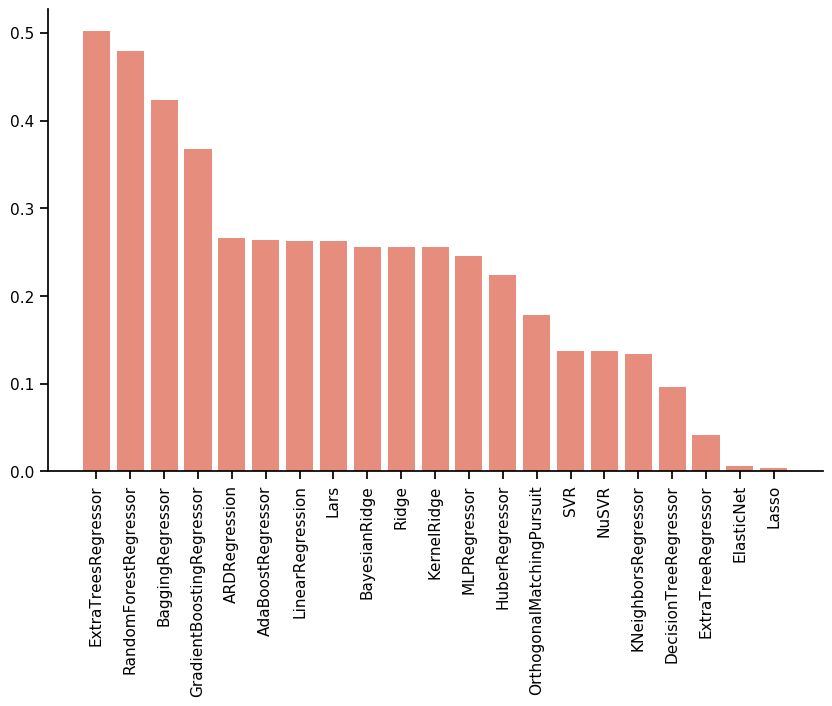

In [176]:
sort!(regressors, :score, rev=true)
fig, ax = subplots(figsize=(10, 6))
ax.bar(regressors[!, :name], regressors[!, :score], color=my_colors[:red])
xticks(rotation=90)
# ax.set_facecolor(my_colors[:gray])
sns.despine()

In [180]:
# max_features = ["auto", "sqrt", "log2"]
max_features = 1:length(features)
for mf in max_features
    reg = ExtraTreesRegressor(max_features=mf)
    reg.fit(X_train, y_train)
    println(mf, " ", reg.score(X_validate, y_validate))
end

1 0.49402178010101094
2 0.5050222484224134
3 0.5050288124959763
4 0.5112670454473731
5 0.5041639301633065
6 0.5069402707175414
7 0.5144665061834836
8 0.5066803334044441
9 0.5092668409512353
10 0.506531591497505
11 0.50685060547267
12 0.499710074969294


In [186]:
for mf in ["mse", "mae"]
    reg = ExtraTreesRegressor(criterion=mf)
    reg.fit(X_train, y_train)
    println(mf, " ", reg.score(X_validate, y_validate))
end

mse 0.5037652283350857
mae 0.4973429387609806


In [12]:
n_est = 10 .^ range(0, stop=3)
n_est = vcat(n_est, 5 * n_est)
est_scores = [NaN for _ in n_est]
for (i, est) in enumerate(n_est)
    reg = ExtraTreesRegressor(n_estimators=est, n_jobs=-1)
    reg.fit(X_tv, y_tv)
    est_scores[i] = reg.score(X_test, y_test)
end

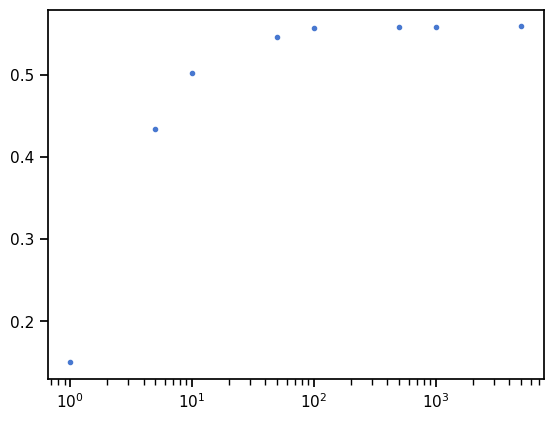

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000004674AC18>

In [13]:
semilogx(n_est, est_scores, ".")

In [45]:
using ScikitLearn.GridSearch: RandomizedSearchCV
using ScikitLearn: fit!
@sk_import ensemble : ExtraTreesRegressor
n_est = 10 .^ range(0, stop=3)
n_est = vcat(n_est, 5 * n_est)
reg = ExtraTreesRegressor(n_jobs=-1)
gsc = RandomizedSearchCV(
    estimator=reg,
    param_distributions=Dict(
        :n_estimators => n_est,
        :max_features => [length(features)],
    ),
    cv=5,
    verbose=1
)
fit!(gsc, X_tv, y_tv)

Fitting 5 folds for each of 10 candidates, totalling 50 fits

RandomizedSearchCV
  estimator: PyObject
  param_distributions: Dict{Symbol,Array{Int64,1}}
  n_iter: Int64 10
  scoring: Nothing nothing
  fit_params: Dict{Any,Any}
  n_jobs: Int64 1
  iid: Bool true
  refit: Bool true
  cv: Int64 5
  verbose: Int64 1
  random_state: Random.MersenneTwister
  error_score: String "raise"
  scorer_: score (function of type typeof(ScikitLearnBase.score))
  grid_scores_: Array{ScikitLearn.Skcore.CVScoreTuple}((10,))
  best_estimator_: PyObject
  best_score_: Float64 0.512712307691972
  best_params_: Dict{Symbol,Any}


In [46]:
bp = gsc.best_params_

Dict{Symbol,Any} with 2 entries:
  :max_features => 12
  :n_estimators => 1000

In [47]:
reg = ExtraTreesRegressor(
    n_jobs=-1,
    max_features=bp[:max_features],
    n_estimators=bp[:n_estimators]
)
reg.fit(X_tv, y_tv)
reg.score(X_test, y_test)

0.5586806184422052

In [ ]:
ExtraTreesRegressor()

## Fit model

## Validate model

In [ ]:
reg = LinearSVR()

In [51]:
[Symbol("volatile acidity"), Symbol("residual sugar"), Symbol("free sulfur dioxide"), Symbol("total sulfur dioxide"), :sulphates, :alcohol]

6-element Array{Symbol,1}:
 Symbol("volatile acidity")    
 Symbol("residual sugar")      
 Symbol("free sulfur dioxide") 
 Symbol("total sulfur dioxide")
 :sulphates                    
 :alcohol                      

In [53]:
Symbol[Symbol("volatile acidity"), Symbol("residual sugar"), Symbol("free sulfur dioxide"), Symbol("total sulfur dioxide"), :pH, :alcohol] 

6-element Array{Symbol,1}:
 Symbol("volatile acidity")    
 Symbol("residual sugar")      
 Symbol("free sulfur dioxide") 
 Symbol("total sulfur dioxide")
 :pH                           
 :alcohol                      